In [15]:
import numpy as np
import math
import os
import random
from matplotlib import pyplot as plt
import queue
import collections
import seaborn as sns
PAGE_SIZE = 4096                    # Page Size in Bytes
NP = 6                              # No. of processes in memory
F = 16                              # No. of Frames in physical memory
INVALID = -10
PID = 0                             # Used for Indexing into Frames
FRAME = 1                           # Used for Indexing into Frames
COMPLETED = 10                      # Process Status Flags
INCOMPLETE = 20                     #
# The following are page replacement algorithm types
FIFO_GLOBAL = 10
oldest_frame = 0
loc_oldest_frame = np.zeros(F).astype('int32')
phys_mem = np.full((F,2), INVALID).astype('int32')     #For First In First Out.
phys_memLRU = np.full((F,2), INVALID).astype('int32')  #For Least Recently Used.
phys_memRR = np.full((F,2), INVALID).astype('int32')     #For Random Replacement.
phys_memMFU = np.full((F,2), INVALID).astype('int32')  #For Most Frequently Used.
phys_memLFU = np.full((F,2), INVALID).astype('int32')  #For Least Frequently Used.
pr_status = np.full(NP, INCOMPLETE).astype('int32')

In [16]:
def init_proc_queue() :
    pq = queue.Queue(maxsize=NP)
    proc_queue = list(set((NP * np.random.random(20)).astype('int32')))
    random.shuffle(proc_queue)
    print(proc_queue)
    for pr in proc_queue:
        pq.put_nowait(pr)
    return(pq)



def sim_process(M, sigma, outfile, lfrac=0.9) :
    cur_page = int(M * np.random.random())  # Generate a random start page
    cur_locale = round(PAGE_SIZE * (cur_page + 0.5))  #Locality of reference
    sum_refs = 0
    list_locales = list()
    for count in range(M) :
        num_refs = int(512 + (PAGE_SIZE - 512) * np.random.random()) # random page address in memory.
        sum_refs += num_refs
        list_locales.append(cur_page)
        num_loc = round(lfrac * num_refs)
        aref_list = np.random.normal(cur_locale, sigma * 300 + 100,
                                    num_loc)   #If siagma is less, it stays less within that locality of reference
        #if sigma more, it may vary more
        aref_list = correct_refs(aref_list, cur_locale, M)
        aref_list = aref_list.astype('int32')
        cur_page = int(M * np.random.random())
        cur_locale = round(PAGE_SIZE * (cur_page + 0.5))
        num_trans = round((1 - lfrac) * num_refs)
        tref_list = np.random.random(num_trans) * cur_locale
        tref_list = correct_refs(tref_list, 0, M)
        tref_list = tref_list.astype('int32')
        np.append(aref_list, tref_list).tofile(outfile, sep='\n')
        outfile.write('\n')
    
    return list_locales, sum_refs

#This block of code will control if sigma value is more.

def correct_refs(alist, cent, maxpg) :
    if cent != 0 :
        pgnum = int(cent / PAGE_SIZE)
        lh = (pgnum + 1) * PAGE_SIZE - 1
        ll = pgnum * PAGE_SIZE
    else :
        lh = maxpg * PAGE_SIZE
        ll = 0
    for i in range(alist.shape[0]) :
        if alist[i] >= lh :
            alist[i] = lh - 1
        if alist[i] < ll :
            alist[i] = ll + 1
    return alist

In [17]:
##################################################################
# The page replacement algorithm wrapper is defined here
##################################################################
def get_oldest_frame(pr, algo_type) :
    global oldest_frame
    if algo_type == FIFO_GLOBAL :
        rv = oldest_frame
        oldest_frame += 1
        if oldest_frame == F :
            oldest_frame = 0
        return rv
        
    return INVALID

In [18]:
def init_phys_mem() :
    for i in range(F) :
#         initializing Physical memory to implement FIFO
        phys_mem[i,PID] = INVALID
        phys_mem[i,FRAME] = INVALID
        
#         initializing Physical memory to implement LRU
        phys_memLRU[i,PID] = INVALID
        phys_memLRU[i,FRAME] = INVALID
        
def update_phys_mem(pid) :
    for i in range(F) :
#         Updating physical memory of FIFO
        if phys_mem[i,PID] == pid :
            phys_mem[i,PID] = INVALID
            phys_mem[i,FRAME] = INVALID
            
#         Updating physical memory of LRU
        if phys_memLRU[i,PID] == pid :
            phys_memLRU[i,PID] = INVALID
            phys_memLRU[i,FRAME] = INVALID
        
def mem_manager(infile, outfile1,outfile2, pid) :
#    num_faults = 0
    # Read a number of address references, i.e., execute the process
    # partially (or fully, if the number generated is > process size)
    num_addr = 512 + int(4096 * np.random.random())
    idx = 0
    while idx < num_addr :
        addr_ref = infile.readline().strip()
        if addr_ref == '' :
            break
        addr_ref = int(addr_ref)
        pg_num = int(addr_ref / PAGE_SIZE)
        pg_offset = addr_ref % PAGE_SIZE
        pg_base1, pg_fault1 = get_pageframe(pg_num, pid,lru=False)   #Trying to fetch fault for FIFO.
        pg_base2, pg_fault2 = get_pageframe(pg_num, pid,lru=True)    #Trying to fetch fault for LRU=True
        
#Both get_pageframe function is run for FIFO and LRU with their individual phys_memories with same input running together.

        if  pg_base1 >= 0 :
            phys_addr = pg_base1 + pg_offset
            outfile1.write(str(addr_ref) + ',' + str(phys_addr) + ','
                          + str(pg_fault1) + '\n')          #Saving the logical add, physical add and faults for FIFO
        
            if pg_fault1 == 0 :
                pr_timing[pid] += IN_MEMORY
            elif pg_fault1 == 1 :
                pr_timing[pid] += MEM_FAULT
            else :
                pr_timing[pid] += PAGE_REPLACE
                
        if  pg_base2 >= 0 :                                  #Saving the logical add, physical add and faults for LRU
            phys_addr = pg_base2 + pg_offset
            outfile2.write(str(addr_ref) + ',' + str(phys_addr) + ','
                          + str(pg_fault2) + '\n')
        
        
        else :
            print(idx)
            return INVALID
        idx += 1
        
    if idx >= num_addr :    
        return INCOMPLETE
    return COMPLETED


def get_pageframe(pnum, pr,lru=False) :
    global phys_mem
    global phys_memLRU
    fr_num = 0
    if lru:
        while fr_num < F :
            if phys_memLRU[fr_num,PID] == pr and phys_memLRU[fr_num,FRAME] == pnum :
                temp=phys_memLRU[fr_num]
                phys_memLRU=np.delete(phys_memLRU,fr_num,axis=0)
                phys_memLRU=np.concatenate([phys_memLRU,temp.reshape(1,-1)],axis=0)
                break
            else :
                fr_num += 1
    else:
        while fr_num < F :
            if phys_mem[fr_num,PID] == pr and phys_mem[fr_num,FRAME] == pnum :
                break
            else :
                fr_num += 1

    if fr_num < F :
        return fr_num * PAGE_SIZE, 0
    
    if lru:
        fr_num = gen_pagefault(pnum, pr,lru=True)
    else:
        fr_num = gen_pagefault(pnum, pr,lru=False)
        
    if fr_num >= 0 :
        return fr_num * PAGE_SIZE, 1
    
    if lru:
        fr_num = page_replace(pnum, pr)
    else:
        fr_num = page_replaceFIFO(pnum, pr)
        
    if fr_num >= 0 :
        return fr_num * PAGE_SIZE, 2
    return INVALID, 0

def gen_pagefault(pgnum, pr,lru=False) :
    fr_num = 0
    if lru:
        while fr_num < F and phys_memLRU[fr_num,FRAME] >= 0 :
            fr_num += 1
        if fr_num >= F :
            return INVALID
        phys_memLRU[fr_num,FRAME] = pgnum
        phys_memLRU[fr_num,PID] = pr
    else:
        while fr_num < F and phys_mem[fr_num,FRAME] >= 0 :
            fr_num += 1
        if fr_num >= F :
            return INVALID
        phys_mem[fr_num,FRAME] = pgnum
        phys_mem[fr_num,PID] = pr
        
    return fr_num

def page_replace(pgnum, pr):
    global phys_memLRU
    temp=np.array([pr,pgnum])
    phys_memLRU=np.delete(phys_memLRU,0,axis=0)
    phys_memLRU=np.concatenate([phys_memLRU,temp.reshape(1,-1)],axis=0)
    return F-1


def page_replaceFIFO(pgnum, pr, algo=FIFO_GLOBAL) :
    cur_frame = get_oldest_frame(pr, algo)
    phys_mem[cur_frame,PID] = pr
    phys_mem[cur_frame,FRAME] = pgnum
    return cur_frame

def print_phys_mem() :
    print('{:^10s} {:^6s} {:^6s}'.format('Frame', 'PID', 'Page No.'))
    print('{:^10s} {:^6s} {:^6s}'.format('-----', '---', '--------'))
    for i in range(F) :
        if phys_mem[i, PID] != INVALID :
            print('{:^10d} {:^6d} {:^6d}'.format(i, phys_mem[i, PID],
                                               phys_mem[i,FRAME]))
        else:
            print('Free Frame: ', i)
    print('_____________________________________________________________')
    print('{:^10s} {:^6s} {:^6s}'.format('Frame', 'PID', 'Page No.'))
    print('{:^10s} {:^6s} {:^6s}'.format('-----', '---', '--------'))
    for i in range(F) :
        if phys_memLRU[i, PID] != INVALID :
            print('{:^10d} {:^6d} {:^6d}'.format(i, phys_memLRU[i, PID],
                                               phys_memLRU[i,FRAME]))
        else:
            print('Free Frame: ', i)
            
def readq(q):
    while True:
        try:
            yield q.get_nowait()
        except queue.Empty:
            break

In [19]:
# pr_size = np.zeros(NP, dtype='int32')
# for p in range(NP) :
#     fname = 'AR_' + '{:02d}'.format(p) + '.txt'
#     op = open(fname, 'w')
#     npg = int(np.random.normal(10,2.5))
#     nsig = int(5 * np.random.random())
#     print(f'Process {p} requires {npg} pages and has a quality {nsig}')
#     pg_seq, pr_size[p] = sim_process(npg, nsig, op)
#     print(pg_seq, pr_size[p])
#     op.write('\n')
#     op.close()
#     print('Written process ', p, 'to ', fname)

In [20]:
# We assume that Process Simulator(s) has(ve) been run earlier.
# Otherwise do so now! Or else memory manager will fail gracefully?

# Initialise Physical Memory and Process Queue
init_phys_mem()
oldest_frame = 0
pr_que = init_proc_queue()
pr_timing = np.zeros(F).astype('int32')
IN_MEMORY = 1
MEM_FAULT = 50
PAGE_REPLACE = 100

# Open necessary files
infiles = list()
outfiles1 = list()
outfiles2 = list()
for i in range(NP) :
    fname = 'AR_{:02d}.txt'.format(i)
    outname1 = 'AR_{:02}_out.txt'.format(i)
    outname2 = 'ARLRU_{:02}_out.txt'.format(i)
    
    if os.access(fname, os.R_OK) :
        print(f'Reading Process from {fname}')
        infiles.append(open(fname, 'r'))
    else:
        print(f'Cannot open {fname} for reading')
    outfiles1.append(open(outname1, 'w'))
    outfiles2.append(open(outname2, 'w'))

# Map logical into physical addresses and keep track of page faults
for pr in readq(pr_que) :
    rv = mem_manager(infiles[pr], outfiles1[pr],outfiles2[pr], pr)
    if rv == INVALID :
        print('Memory overflow error')
        break
    if rv == INCOMPLETE :
        pr_que.put_nowait(pr)
    else :
#         print(f'Process {pr} (Size: {pr_size[pr]} Bytes) completed; \
#         removing from queue')
#         print(f'Time taken: {pr_timing[pr]}')
#         slow = (pr_timing[pr] - pr_size[pr]) * 100.0 / pr_size[pr]
#         print('Slow down by {:.2f}%'.format(slow))
        print_phys_mem()
        update_phys_mem(pr)
        
#        print('Current Status of Physical Memory')
#        print_phys_mem()

# Close all files
for i in range(NP) :
    infiles[i].close()
    outfiles1[i].close()
    outfiles2[i].close()
    
# Print the Pages in Physical Memory

[2, 1, 4, 0, 5, 3]
Reading Process from AR_00.txt
Reading Process from AR_01.txt
Reading Process from AR_02.txt
Reading Process from AR_03.txt
Reading Process from AR_04.txt
Reading Process from AR_05.txt
  Frame     PID   Page No.
  -----     ---   --------
    0        0      1   
    1        5      7   
    2        3      8   
    3        3      0   
    4        3      1   
    5        3      3   
    6        3      2   
    7        2      0   
    8        2      2   
    9        2      3   
    10       2      4   
    11       2      1   
    12       0      3   
    13       0      4   
    14       0      2   
    15       0      6   
_____________________________________________________________
  Frame     PID   Page No.
  -----     ---   --------
    0        0      1   
    1        0      5   
    2        0      3   
    3        0      6   
    4        0      0   
    5        5      7   
    6        3      8   
    7        3      2   
    8        3      1   


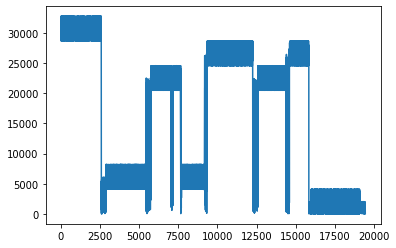

In [21]:
a=np.loadtxt('AR_00.txt')
plt.plot(a)

In [22]:
pq = queue.Queue(maxsize=NP)
proc_queue = list(set((NP * np.random.random(20)).astype('int32')))
random.shuffle(proc_queue)
print(proc_queue)
for pr in proc_queue:
    pq.put_nowait(pr)


[4, 5, 1, 2, 3, 0]


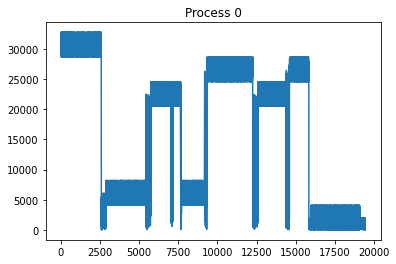

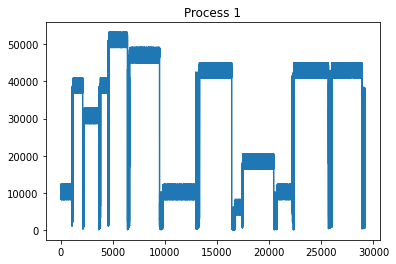

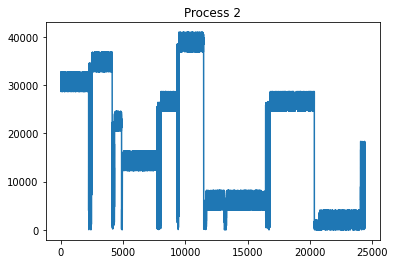

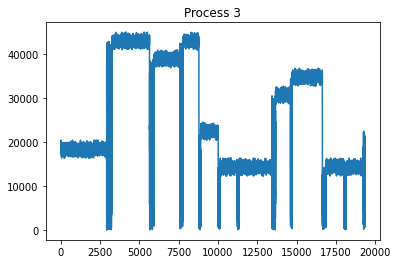

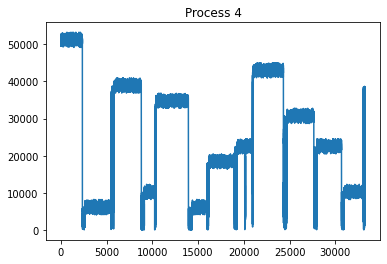

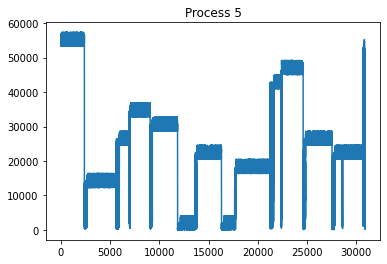

In [23]:
for i,p in enumerate(range(NP)) :
    fname = 'AR_' + '{:02d}'.format(p) + '.txt'
    data=np.loadtxt(fname)
    plt.plot(data)
    plt.title('Process {}'.format(i))
    plt.show()

In [24]:
file=open('AR_00_out.txt','r')
data=file.read()
datas=np.array(data.split('\n'))
faults=[data[-1] for data in datas[:-1]]

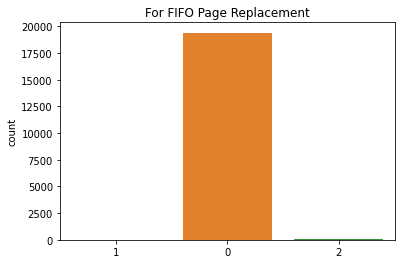

In [25]:
plt.title("For FIFO Page Replacement")
sns.countplot(x=faults)
plt.show()

In [26]:


collections.Counter(faults)

Counter({'1': 2, '0': 19417, '2': 33})

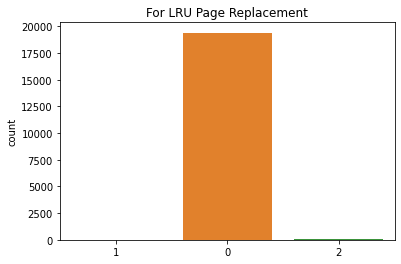

In [27]:
file=open('ARLRU_00_out.txt','r')
data=file.read()
datas=np.array(data.split('\n'))
faults=[data[-1] for data in datas[:-1]]
sns.countplot(x=faults)
plt.title("For LRU Page Replacement")
plt.show()

In [28]:
collections.Counter(faults)

Counter({'1': 2, '0': 19417, '2': 33})